In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [60]:
BATCH_SIZE = 100

In [61]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        directory=r"./images/",
        target_size=(28, 28),
        batch_size=BATCH_SIZE,
        classes=None,
        class_mode=None,
        shuffle=True,
        color_mode = 'rgb')

Found 63500 images belonging to 1 classes.


In [62]:
BUFFER_SIZE = train_generator.samples // BATCH_SIZE * BATCH_SIZE

In [147]:
# формирование сетей
hidden_dim = 2

def dropout_and_batch():
    return Dropout(0.3)(BatchNormalization())

In [148]:
# генератор
generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])

In [149]:
generator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 12544)             37632     
                                                                 
 batch_normalization_27 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 7, 7, 128)        819328    
 Transpose)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                                     

In [150]:
# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 3]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

In [151]:
discriminator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        4864      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_20 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_21 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_10 (Flatten)        (None, 6272)            

In [152]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [153]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [154]:
# обучение
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return gen_loss, disc_loss

In [155]:
def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

    for epoch in range(1, epochs + 1):
        print(f'{epoch}/{EPOCHS}: ', end='')
        start = time.time()
        n = 0
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

        gen_loss_epoch = 0
        for image_batch in dataset:
            
            if n<STEP_SIZE_TRAIN:
                gen_loss, disc_loss = train_step(tf.constant(image_batch))
                gen_loss_epoch += K.mean(gen_loss)
                if (n % th == 0): 
                    print('=', end='')
                n += 1
            else:
                break

        history += [gen_loss_epoch / n]
        print(': ' + str(history[-1]))
        print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

    return history

In [156]:
# запуск процесса обучения
EPOCHS = 100
history = train(train_generator, EPOCHS)

1/100: ===========: tf.Tensor(0.6788234, shape=(), dtype=float32)
Время эпохи 1 составляет 42.71035408973694 секунд
2/100: ===========: tf.Tensor(0.7014611, shape=(), dtype=float32)
Время эпохи 2 составляет 38.78138279914856 секунд
3/100: ===========: tf.Tensor(0.7207553, shape=(), dtype=float32)
Время эпохи 3 составляет 38.35525465011597 секунд
4/100: ===========: tf.Tensor(0.74243724, shape=(), dtype=float32)
Время эпохи 4 составляет 38.30006265640259 секунд
5/100: ===========: tf.Tensor(0.75393605, shape=(), dtype=float32)
Время эпохи 5 составляет 38.383862018585205 секунд
6/100: ===========: tf.Tensor(0.74994934, shape=(), dtype=float32)
Время эпохи 6 составляет 38.302984952926636 секунд
7/100: ===========: tf.Tensor(0.7322477, shape=(), dtype=float32)
Время эпохи 7 составляет 39.89626741409302 секунд
8/100: ===========: tf.Tensor(0.73381716, shape=(), dtype=float32)
Время эпохи 8 составляет 38.37136125564575 секунд
9/100: ===========: tf.Tensor(0.72665113, shape=(), dtype=float32)

71/100: ===========: tf.Tensor(0.91806024, shape=(), dtype=float32)
Время эпохи 71 составляет 36.981274127960205 секунд
72/100: ===========: tf.Tensor(0.9603027, shape=(), dtype=float32)
Время эпохи 72 составляет 37.14173769950867 секунд
73/100: ===========: tf.Tensor(0.91221297, shape=(), dtype=float32)
Время эпохи 73 составляет 37.04233527183533 секунд
74/100: ===========: tf.Tensor(0.92620283, shape=(), dtype=float32)
Время эпохи 74 составляет 37.122448682785034 секунд
75/100: ===========: tf.Tensor(0.9247552, shape=(), dtype=float32)
Время эпохи 75 составляет 37.04978561401367 секунд
76/100: ===========: tf.Tensor(0.9077214, shape=(), dtype=float32)
Время эпохи 76 составляет 37.19065189361572 секунд
77/100: ===========: tf.Tensor(0.9038401, shape=(), dtype=float32)
Время эпохи 77 составляет 37.25498414039612 секунд
78/100: ===========: tf.Tensor(0.9201489, shape=(), dtype=float32)
Время эпохи 78 составляет 37.02734303474426 секунд
79/100: ===========: tf.Tensor(0.9237867, shape=(),

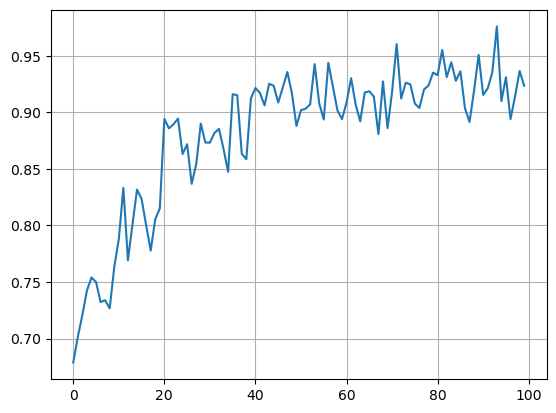

In [157]:
plt.plot(history)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 25ms/step


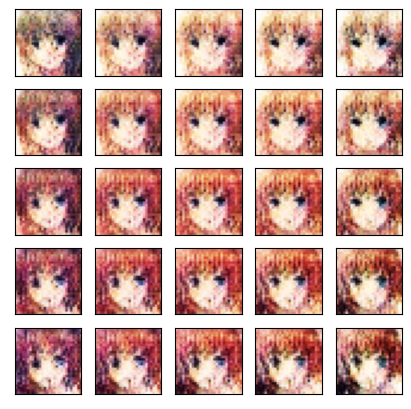

In [161]:
# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

im =  None
num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
        plt.imshow(np.squeeze(img, axis=0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)